# Filter Bank Common Spatial Pattern
Attempt at implementing filter-bank common spatial filter (FBCSP) on BCI Competition IV 2a Dataset
  
**References:**   

[1] Kai Keng Ang, Zheng Yang Chin, Haihong Zhang and Cuntai Guan, "Filter Bank Common Spatial Pattern (FBCSP) in Brain-Computer Interface," 2008 IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), Hong Kong, 2008, pp. 2390-2397, doi: 10.1109/IJCNN.2008.4634130.    
[2] Ang, K. K., Chin, Z. Y., Wang, C., Guan, C., & Zhang, H. (2012). Filter Bank Common Spatial Pattern Algorithm on BCI Competition IV Datasets 2a and 2b. Frontiers in Neuroscience, 6. doi: 10.3389/fnins.2012.00039

# BCI Competition IV Dataset 2a (.npz data)
Information Given in Documentation

From the documentation it is known that:
* 25 electrodes are used, first 22 are EEG, last 3 are EOG
* Sampling frequency (fs) is 250Hz
* 9 subjects
* 9 run (run 1-3 are for eye movement, run 4-9 is MI)  
  

**-- Time Duration--**  
1 trials                          = 7-8s  
1 run              = 48 trials    = 336-384s  
1 session = 6 runs = 288 trials   = 2016-2304s

About the recording of eye movement
* run 1 => 2 mins with eyes open
* run 2 => 1 min with eyes closed
* run 3 => 1 min with eye movements

![timing-scheme-paradigm.png](https://github.com/orvindemsy/BCICIV2a-FBCSP/blob/master/img/timing-scheme-paradigm.png?raw=1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
!pip install mne
!pip install tensorflow

import numpy as np
import pandas as pd
import torch as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy import signal
import mne
from mne.datasets import sample
from mne.preprocessing import EOGRegression
from scipy.signal import spectrogram
import tensorflow as tf
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from keras.utils import to_categorical

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F


In [ ]:
!git clone https://github.com/vlawhern/arl-eegmodels.git
%cd arl-eegmodels
from EEGModels import EEGNet


fatal: destination path 'arl-eegmodels' already exists and is not an empty directory.
/content/arl-eegmodels


# Loading dataset

In [ ]:
# Clone the repository
!git clone https://github.com/orvindemsy/BCICIV2a-FBCSP.git

# Navigate to the folder (if needed)
%cd BCICIV2a-FBCSP/datasets

fatal: destination path 'BCICIV2a-FBCSP' already exists and is not an empty directory.
/content/arl-eegmodels/BCICIV2a-FBCSP/datasets


In [ ]:
# First import the data
results_df = pd.DataFrame(columns=['subj', 'avg', 'sd', 'se'])

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
# mod_data will contain modified original data|
ori_data = dict()
mod_data = dict()


In [ ]:
# Function to count subject
def subject_counter(i):
    return 'subject0{}'.format(i)

In [ ]:
# Path manipulation if running in dev container
if os.getcwd() == '/':
    print("Running the notebook it inside dev container..")
    base_dir = os.environ["DOCKER_WORKDIR"]
else:
    print("Running the notebook locally..")
    base_dir = os.getcwd()

Running the notebook locally..


In [ ]:
# Load the training data of all subjects

# Iter over all data path then store them in sub0X variable
for i in range(1, ns):
    data_path = os.path.join(base_dir, './A{:02d}T.npz'.format(i))
    subject = 'subject{:02d}'.format(i)

    # Load EEG data from datapath and store into subj0X variabel then store into data dictionary
    ori_data[subject] = np.load(data_path)


In [ ]:
# Peek into ori_data type and its keys
print(type(ori_data['subject01']))
print(ori_data['subject01'].files)

<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']


In [ ]:
ori_data['subject01']['artifacts'].ravel()[20:50]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

Explanation regarding contents of the keys inside each subject data:
* **s**: 's' contains continuous time-series recorded EEG signals are, shape of M x N array. Size may vary between subjects but N is fixed to 25, indicates 25 electrodes with 22 first EEG and 3 last EOG
* **etype**: 'etyp' stands for event type which indicate event occurence, event code will be describe in subsequent table
* **epos**: 'epos' stands for event position, denoting corresponding event begins at n-th sample at **'s'**
* **edur**: 'edur' stands for event duration, denoting duration of corresponding event
* **artifacts**: size of 288 x 1, 288 comes form 6 x 48, 6 runs where @run has 48 trials, @class has 12 trials

In [ ]:
# ori_data will contain original data that is the raw file
# mod_data will contain modified original data

# Initialize 'subject0x' dict inside mod_data
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj] = {}

In [ ]:
# Peek into different shape of recorded data/'s' between subjects
print('Sample\tElectrodes')
for i in range(1, ns):
    subj_temp = subject_counter(i)
    print(ori_data[subj_temp]['s'].shape)

Sample	Electrodes
(672528, 25)
(677169, 25)
(660530, 25)
(600915, 25)
(686120, 25)
(678980, 25)
(681071, 25)
(675270, 25)
(673328, 25)


In [ ]:
# First extract the sample data from ori_data into mod_data
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj]['raw_EEG'] = ori_data[subj]['s']

In [ ]:
# Visualizing sample_data inside subject01
# You can see that it has 25 electrodes stored in n columns
pd.DataFrame(mod_data['subject01']['raw_EEG']).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-21.142578,-23.681641,-21.484375,-25.146484,-25.732422,-27.929688,-14.550781,-22.509766,-25.439453,-28.710938,...,-30.615234,-29.638672,-26.660156,-20.947266,-25.439453,-24.902344,-19.677734,31.738281,-13.671875,-43.945312
1,-21.923828,-23.925781,-24.316406,-25.341797,-26.074219,-25.244141,-16.064453,-22.753906,-28.320312,-29.248047,...,-31.054688,-30.712891,-26.123047,-22.998047,-27.099609,-26.367188,-23.339844,22.460938,-13.183594,-40.527344
2,-15.625000,-19.726562,-18.847656,-21.582031,-20.751953,-21.728516,-12.451172,-20.410156,-23.730469,-25.927734,...,-28.759766,-28.417969,-24.462891,-21.386719,-25.097656,-24.267578,-21.484375,33.691406,-8.300781,-38.574219
3,-16.699219,-13.720703,-20.361328,-20.849609,-24.169922,-22.021484,-10.986328,-16.357422,-25.585938,-24.951172,...,-27.783203,-28.857422,-25.537109,-19.335938,-24.316406,-24.511719,-17.919922,41.992188,-7.324219,-38.574219
4,-19.335938,-17.626953,-20.410156,-26.464844,-27.392578,-29.882812,-9.277344,-18.359375,-24.609375,-30.517578,...,-31.884766,-33.740234,-32.666016,-18.554688,-26.611328,-28.466797,-18.408203,37.109375,-15.136719,-49.804688


# Preprocessing

In [ ]:
# Removing last three EOG electrode using np.delete, store data as EEG_only to each subject dict
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj]['raw_EEG'] = np.delete(mod_data[subj]['raw_EEG'], np.s_[22:], 1)

mod_data['subject01']['raw_EEG'].shape

(672528, 22)

## Bandpass Filtering
The first stage employing a filter bank is to decompose EEG into multiple frequency pass band, using causal Chebysev Type II filter/ Butterworth Filter.  
A total of 9 band-pass filters are used, namely, 4-8, 8-12, ... 36-40 Hz  
These frequency ranges are used because they yielf a stable frequency response and cover range of 4-40 Hz

In [ ]:
# Band pass filter with butterworth filter
from scipy.signal import butter, lfilter
from scipy.signal import freqz

In [ ]:
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal, axis=-1)

    return y

### Practice
Create arbitrary signal and using butterworth signal as band-pass filter

In [ ]:
"""
# INPUT
# sampling frequency
fs = 500

# time
t = np.arange(0, 5, 1/fs)

# Three signals with various freq
x1 = np.sin(2 * np.pi * 6 * t)
x2 = np.sin(2 * np.pi * 7 * t)
x3 = np.sin(2 * np.pi * 50 * t)
x = x1 + x2 + x3

# Plot input
plt.figure(figsize=(5, 3), dpi=80)
plt.clf()
plt.plot(t, x)
plt.xlabel('time (seconds)')
plt.show()
"""

"\n# INPUT\n# sampling frequency\nfs = 500\n\n# time\nt = np.arange(0, 5, 1/fs)\n\n# Three signals with various freq\nx1 = np.sin(2 * np.pi * 6 * t)\nx2 = np.sin(2 * np.pi * 7 * t)\nx3 = np.sin(2 * np.pi * 50 * t)\nx = x1 + x2 + x3\n\n# Plot input\nplt.figure(figsize=(5, 3), dpi=80)\nplt.clf()\nplt.plot(t, x)\nplt.xlabel('time (seconds)')\nplt.show()\n"

In [ ]:
"""# OUTPUT
lowcut = 4
highcut = 8
y= butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

# Plot output
plt.figure(figsize=(5, 3), dpi=80)
plt.clf()
plt.plot(t, y, label='Filtered signal (%g Hz)' %fs)
plt.xlabel('time (seconds)')
plt.grid(True)
plt.show()

del x1, x2, x3, x, t, y
"""

"# OUTPUT\nlowcut = 4\nhighcut = 8\ny= butter_bandpass_filter(x, lowcut, highcut, fs, order=5)\n\n# Plot output\nplt.figure(figsize=(5, 3), dpi=80)\nplt.clf()\nplt.plot(t, y, label='Filtered signal (%g Hz)' %fs)\nplt.xlabel('time (seconds)')\nplt.grid(True)\nplt.show()\n\ndel x1, x2, x3, x, t, y\n"

### Filtering EEG signal with Butterworth Band-pass
Following the steps mentioned in [1], there will be 8 band-pass filter with bandwidth of:
1. 4-8Hz
2. 8-12Hz
3. 12-16Hz
4. 16-20Hz
5. 20-24Hz
6. 24-28Hz
7. 28-32Hz
8. 32-36Hz
9. 36-40Hz

*Note*   
Apply filter to the time-series axis, thus set 'raw_EEG' inside each subject to shape of N x T (i.e. electrodes x samples)

In [ ]:
# Transpose all 'raw_EEG' data
for i in range(1, ns):
    subj = subject_counter(i)

    while mod_data[subj]['raw_EEG'].shape[0] != 22:
        mod_data[subj]['raw_EEG'] = mod_data[subj]['raw_EEG'].T

    print(mod_data[subj]['raw_EEG'].shape)

(22, 672528)
(22, 677169)
(22, 660530)
(22, 600915)
(22, 686120)
(22, 678980)
(22, 681071)
(22, 675270)
(22, 673328)


In [ ]:
# Create function that could bandpass filtered one subject
def butter_bandpass_one_subject(data, subj, lowcut, highcut, fs, interval=None):
    print('Processing ', subj)

    # Create new key 'EEG_filtered' to store filtered EEG of each subject
    data[subj]['EEG_filtered'] = {}

    # Current raw EEG
    temp_raw_EEG = data[subj]['raw_EEG']

    if interval is not None:
        startband = np.arange(lowcut, highcut, step = interval)

        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start+interval)

            print('Filtering through {} Hz band'.format(band))
            # Bandpass filtering
            data[subj]['EEG_filtered'][band] = {}
            data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, start, start+interval, fs)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, lowcut, highcut, fs)

In [ ]:
# Bandpass filtering all subject
lowcut=4
highcut=40
fs = 250

amount_subjects = 1

subject = 9

# Iterate over subjects
for i in range(1, amount_subjects + 1):
    subj = subject_counter(subject)
    butter_bandpass_one_subject(mod_data, subj, lowcut, highcut, fs, interval=4)
    print('')



Processing  subject09
Filtering through 04_08 Hz band
Filtering through 08_12 Hz band
Filtering through 12_16 Hz band
Filtering through 16_20 Hz band
Filtering through 20_24 Hz band
Filtering through 24_28 Hz band
Filtering through 28_32 Hz band
Filtering through 32_36 Hz band
Filtering through 36_40 Hz band



## Taking EEG data corresponds to left and right class
This work will only clasify two class, left and right hand, meanwhile the data contains four class,  
thus the goal here is to make band-filtered EEG left and right of each class of shape T x C x N, where  
T = trial, C = channel, N = sample

In [ ]:
# First take the position of left and right class
left_class_code = 769
right_class_code = 770
#foot_class_code = 771
#tongue_class_code = 772

for i in range(1, amount_subjects + 1):
    subj = subject_counter(subject)

    mod_data[subj]['left_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == left_class_code]
    mod_data[subj]['right_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == right_class_code]
    # mod_data[subj]['foot_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == foot_class_code]
    # mod_data[subj]['tongue_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == tongue_class_code]



In [ ]:
# Now take EEG data within [0.5 3.5] seconds after cue onset position of each class
start = 0.5
end = 3.5
# print(amount_subjects)
# Please modify this range to add more subject
for i in range(1, amount_subjects + 1):
    subj = subject_counter(subject)
    print('Processing ', subj)
    # Temporary variable of left and right pos
    temp_pos_left = mod_data[subj]['left_pos']
    temp_pos_right = mod_data[subj]['right_pos']
    # temp_pos_foot = mod_data[subj]['foot_pos']
    # temp_pos_tongue = mod_data[subj]['tongue_pos']


    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_EEG_all = mod_data[subj]['EEG_filtered'][band]['EEG_all']
        temp_EEG_left = []
        temp_EEG_right = []
        # temp_EEG_foot = []
        # temp_EEG_tongue = []

        # LEFT
        for j in range(len(temp_pos_left)):
            temp_EEG_left.append(temp_EEG_all[:, temp_pos_left[j] + int(start*fs) : temp_pos_left[j] + int(end*fs)])
        mod_data[subj]['EEG_filtered'][band]['EEG_left'] = np.array(temp_EEG_left)

        # RIGHT
        for j in range(len(temp_pos_right)):
            temp_EEG_right.append(temp_EEG_all[:, temp_pos_right[j] + int(start*fs) : temp_pos_right[j] + int(end*fs)])
        mod_data[subj]['EEG_filtered'][band]['EEG_right'] = np.array(temp_EEG_right)

        # # FOOT
        # for j in range(len(temp_pos_foot)):
        #     temp_EEG_foot.append(temp_EEG_all[:, temp_pos_foot[j] + int(start*fs) : temp_pos_foot[j] + int(end*fs)])
        # mod_data[subj]['EEG_filtered'][band]['EEG_foot'] = np.array(temp_EEG_foot)

        #  # TONGUE
        # for j in range(len(temp_pos_tongue)):
        #     temp_EEG_tongue.append(temp_EEG_all[:, temp_pos_tongue[j] + int(start*fs) : temp_pos_tongue[j] + int(end*fs)])
        # mod_data[subj]['EEG_filtered'][band]['EEG_tongue'] = np.array(temp_EEG_tongue)

Processing  subject09


# Train/Test Data Split

In [ ]:
def split_EEG_one_class(EEG_one_class, percent_train=0.8):
    '''
    split_EEG_one_class will receive EEG data of one class, with size of T x N x M, where
    T = number of trial
    N = number of electrodes
    M = sample number

    INPUT:
    EEG_data_one_class: the data of one class of EEG data

    percent_train: allocation percentage of training data, default is 0.8

    OUTPUT:
    EEG_train: EEG data for training

    EEG_test: EEG data for test

    Both have type of np.arrray dimension of T x M x N
    '''

    # Number of all trials
    n = EEG_one_class.shape[0]

    n_tr = round(n*percent_train)
    n_te = n - n_tr

    EEG_train = EEG_one_class[:n_tr]
    EEG_test = EEG_one_class[n_tr:n_tr+n_te]

    return EEG_train, EEG_test

In [ ]:
# Initialize lists for all subjects data
all_X_train = []
all_y_train = []
all_X_test = []
all_y_test = []

# Iterate over all subjects
for i in range(1, amount_subjects + 1):
    subj = subject_counter(subject)

    # Iterate over each band
    for band in mod_data[subj]['EEG_filtered'].keys():

        # Temporary variables for each band class
        temp_EEG_left = mod_data[subj]['EEG_filtered'][band]['EEG_left']
        temp_EEG_right = mod_data[subj]['EEG_filtered'][band]['EEG_right']
        #temp_EEG_foot = mod_data[subj]['EEG_filtered'][band]['EEG_foot']
        #temp_EEG_tongue = mod_data[subj]['EEG_filtered'][band]['EEG_tongue']

        # Temporary variable to access each band data
        temp_filt = mod_data[subj]['EEG_filtered'][band]

        # Split data into training and test sets
        temp_filt['EEG_left_train'], temp_filt['EEG_left_test'] = split_EEG_one_class(temp_EEG_left, 0.8)
        temp_filt['EEG_right_train'], temp_filt['EEG_right_test'] = split_EEG_one_class(temp_EEG_right, 0.8)
        #temp_filt['EEG_foot_train'], temp_filt['EEG_foot_test'] = split_EEG_one_class(temp_EEG_foot, 0.8)
        #temp_filt['EEG_tongue_train'], temp_filt['EEG_tongue_test'] = split_EEG_one_class(temp_EEG_tongue, 0.8)

"""
        # Concatenate training data for current subject and band
        all_X_train.append(np.concatenate((temp_filt['EEG_left_train'],
                                           temp_filt['EEG_right_train']),
                                          axis=0))
        all_y_train.append(np.concatenate((np.zeros(temp_filt['EEG_left_train'].shape[0]),
                                           np.ones(temp_filt['EEG_right_train'].shape[0])),
                                          axis=0))

        # Concatenate test data for current subject and band
        all_X_test.append(np.concatenate((temp_filt['EEG_left_test'],
                                          temp_filt['EEG_right_test']),
                                         axis=0))
        all_y_test.append(np.concatenate((np.zeros(temp_filt['EEG_left_test'].shape[0]),
                                          np.ones(temp_filt['EEG_right_test'].shape[0])),
                                         axis=0))

# Concatenar los datos de todos los sujetos y bandas
X_train = np.concatenate(all_X_train, axis=0)
y_train = np.concatenate(all_y_train, axis=0)
X_test = np.concatenate(all_X_test, axis=0)
Y_test = np.concatenate(all_y_test, axis=0)

"""

X_train = np.concatenate((mod_data[subj]['EEG_filtered'][band]['EEG_left_train'],
                         mod_data[subj]['EEG_filtered'][band]['EEG_right_train']), axis=0)
y_train = np.concatenate((np.zeros(mod_data[subj]['EEG_filtered'][band]['EEG_left_train'].shape[0]),
                         np.ones(mod_data[subj]['EEG_filtered'][band]['EEG_right_train'].shape[0])), axis=0)

# Do the same for test data
X_test=np.concatenate((mod_data[subj]['EEG_filtered'][band]['EEG_left_test'],
                       mod_data[subj]['EEG_filtered'][band]['EEG_right_test']), axis=0)
Y_test=np.concatenate((np.zeros(mod_data[subj]['EEG_filtered'][band]['EEG_left_test'].shape[0]),
                       np.ones(mod_data[subj]['EEG_filtered'][band]['EEG_right_test'].shape[0])), axis=0)

print(subj)

# Conversión a tensores de PyTorch
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)

print(X_train_tensor.shape)
#del X_train
#del y_train
#del X_test
#del Y_test

subject09
torch.Size([116, 22, 750])


In [ ]:
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt

# class SimpleRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(SimpleRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#         self.dropout = nn.Dropout(p=0.3)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         # Initialize the hidden state
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

#         # Forward propagate RNN
#         out, _ = self.rnn(x, h0)

#         # Apply dropout
#         out = self.dropout(out)

#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out

In [ ]:
# def evaluate_model(model, test_loader):
#     model.eval()
#     test_running_corrects = 0
#     test_total_samples = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             test_running_corrects += (outputs.argmax(1) == labels).sum().item()
#             test_total_samples += labels.size(0)

#     test_acc = test_running_corrects / test_total_samples
#     return test_acc

# def accuracy(outputs, labels):
#     _, predicted = torch.max(outputs, 1)
#     correct = (predicted == labels).sum().item()
#     return correct / labels.size(0)

In [ ]:
# from torch.utils.data import Dataset, DataLoader

# class EEGDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# # Create dataset and dataloader
# train_dataset = EEGDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataset = EEGDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:

# # Hyperparameters
# input_size = X_train_tensor.shape[2]  # Number of features (channels)
# hidden_size = 256
# num_layers = 2
# num_classes = 2
# num_epochs = 4
# learning_rate = 0.001

# num_runs = 10
# test_accuracies = []

# for run in range(num_runs):

#     # Model, loss function, and optimizer
#     model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     # Lists to store metrics information
#     epoch_losses = []
#     epoch_accuracies = []
#     final_test_acc = 0

#     print(f'Run {run + 1}/{num_runs}')

#     # Training loop with accuracy calculation
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         running_corrects = 0
#         total_samples = 0

#         model.train()

#         for i, (inputs, labels) in enumerate(train_loader):

#             inputs, labels = inputs.to(device), labels.to(device)

#             # Forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Calculate loss and accuracy
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += (outputs.argmax(1) == labels).sum().item()
#             total_samples += labels.size(0)

#         epoch_loss = running_loss / total_samples
#         epoch_acc = running_corrects / total_samples

#         # Store metrics for plotting
#         epoch_losses.append(epoch_loss)
#         epoch_accuracies.append(epoch_acc)

#         #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

#     # Test loop for early stopping
#         model.eval()
#         test_loss = 0.0
#         test_corrects = 0
#         test_samples = 0
#         with torch.no_grad():
#             for inputs, labels in test_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 test_loss += loss.item() * inputs.size(0)
#                 test_corrects += (outputs.argmax(1) == labels).sum().item()
#                 test_samples += labels.size(0)

#         test_loss /= test_samples
#         test_acc = test_corrects / test_samples
#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {epoch_acc:.4f}, Test Accuracy: {test_acc:.4f}')
#         #print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
#         test_accuracies.append(test_acc)


# # Calcular el promedio, desviación estándar y error estándar del desempeño del modelo
# mean_acc = np.mean(test_accuracies)
# std_acc = np.std(test_accuracies)
# stderr_acc = std_acc / np.sqrt(num_runs)

# print(f'\nAverage Test Accuracy: {mean_acc:.4f}')
# print(f'Standard Deviation of Test Accuracy: {std_acc:.4f}')
# print(f'Standard Error of Test Accuracy: {stderr_acc:.4f}')



# """
# # Plot loss
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(range(num_epochs), epoch_losses, marker='o', linestyle='-', color='b')
# plt.title('Loss by Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

# # Plot accuracy
# plt.subplot(1, 2, 2)
# plt.plot(range(num_epochs), epoch_accuracies, marker='o', linestyle='-', color='g')
# plt.title('Accuracy by epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

# plt.tight_layout()
# plt.show()

# """

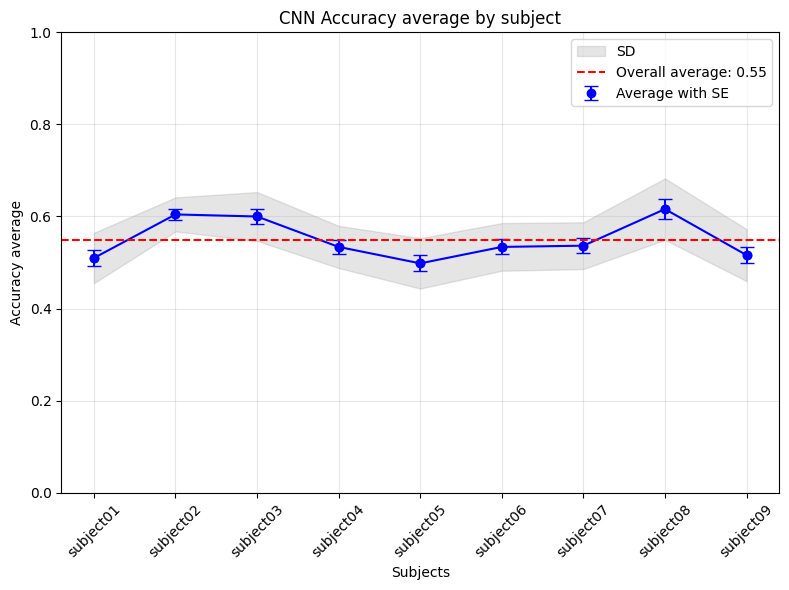

In [ ]:
#results_df = pd.read_csv('/content/results1-8.csv')

#results_df = pd.concat([results_df, pd.DataFrame({'subj': [subj], 'avg': [mean_acc], 'sd': [std_acc], 'se': [stderr_acc]})], ignore_index=True)

results_df = pd.read_csv('/content/results1-9.csv')

#results_df.to_csv('/content/results1-9.csv', index=False)

# Datos del DataFrame
subjects = results_df['subj']
avg = results_df['avg']
sd = results_df['sd']
se = results_df['se']

overall_avg = avg.mean()

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar el promedio de accuracy con barras de error
ax.errorbar(subjects, avg, yerr=se, fmt='o', capsize=5, color = 'blue', label='Average with SE')

# Graficar la banda de desviación estándar
ax.fill_between(subjects, avg - sd, avg + sd, alpha=0.2, color='gray', label='SD')

# Añadir una línea que una los puntos
ax.plot(subjects, avg, marker='o', linestyle='-', color='blue')

ax.axhline(y=overall_avg, color='red', linestyle='--', label=f'Overall average: {overall_avg:.2f}')


plt.ylim(0,1)

# Etiquetas y título
ax.set_xlabel('Subjects')
ax.set_ylabel('Accuracy average')
ax.set_title('CNN Accuracy average by subject')
ax.legend()

# Ajustar las etiquetas del eje X para que no se solapen
plt.xticks(rotation=45)

plt.grid(alpha = .3)


# Mostrar el gráfico
plt.tight_layout()

plt.savefig('/content/RNNresults1-9.png')

plt.show()



In [ ]:

# X_train_cnn=X_train_tensor.cpu().numpy()
# Y_train_cnn=y_train_tensor.cpu().numpy()
# X_test_cnn=X_test_tensor.cpu().numpy()
# Y_test_cnn=y_test_tensor.cpu().numpy()
# Y_train_cnn = to_categorical(Y_train_cnn, num_classes=2)
# Y_test_cnn = to_categorical(Y_test_cnn, num_classes=2)
# model = EEGNet(nb_classes = 2, Chans = 22, Samples = 750 ,
#                dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16,
#                dropoutType = 'Dropout')
# model.compile(loss='categorical_crossentropy', optimizer='adam',
#               metrics = ['accuracy'])
# numParams    = model.count_params()
# checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
#                                save_best_only=True)
# class_weights = {0:1, 1:1, 2:1, 3:1}
# fittedModel = model.fit(X_train_cnn, Y_train_cnn, batch_size = 64, epochs = 5,
#                         verbose = 2, validation_data=(X_test_cnn, Y_test_cnn),
#                         callbacks=[checkpointer], class_weight = class_weights)

# # load optimal weights
# model.load_weights('/tmp/checkpoint.h5')
# probs       = model.predict(X_test_cnn)
# preds       = probs.argmax(axis = -1)
# acc         = np.mean(preds == Y_test_cnn.argmax(axis=-1))
# print("Classification accuracy: %f " % (acc))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 4, (22, 1))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d((1, 4))

        # Layer 3
        self.conv3 = nn.Conv2d(4, 4, (1, 16))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((1, 4))

        # FC Layer
        # Calculate the correct input size for fc1 dynamically
        self.fc1 = nn.Linear(4 * 1 * 39, 1)

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.1)

        # Layer 2
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.1)
        x = self.pooling2(x)

        # Layer 3
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.1)
        x = self.pooling3(x)

        # FC Layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.sigmoid(self.fc1(x))
        return x



In [ ]:
test_accuracies = []

def evaluate(model, X, y, params):
    model.eval()
    with torch.no_grad():
        inputs = torch.from_numpy(X).float()
        labels = torch.FloatTensor(y).float()
        outputs = model(inputs)
        predictions = (outputs > 0.5).float()
        accuracy = (predictions == labels).float().mean()
        return {"acc": accuracy.item()}


In [ ]:
import torch
from torch.autograd import Variable
import numpy as np
X_train = X_train.reshape(-1, 1, 22, 750)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1, 22, 750)
Y_test = Y_test.reshape(-1, 1)

num_runs = 10
test_accuracies = []

for run in range(num_runs):

    print(f'Run {run + 1}/{num_runs}')
    print(i)
    batch_size = 64
    tests=[]

    net = EEGNet()

    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(),lr=0.0001)

    for epoch in range(10):  # loop over the dataset multiple times
        print("\nEpoch ", epoch)

        running_loss = 0.0
        for i in range(len(X_train) // batch_size - 1):
            s = i * batch_size
            e = i * batch_size + batch_size

            inputs = torch.from_numpy(X_train[s:e]).float()
            # Reshape labels to match the output shape (batch_size, 1)
            labels = torch.FloatTensor(y_train[s:e]).float()

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation accuracy
        params = ["acc"]
        #print(params)
        #print("Training Loss ", running_loss)
        print("Train - ", evaluate(net, X_train, y_train, params))
        z=evaluate(net,X_test,Y_test,params)
        print("Test - ", z)
        tests.append(z)

    test_accuracies.append(z['acc'])

# average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
# print("\nAverage Test Accuracy:", average_test_accuracy)
print(test_accuracies)
print(len(test_accuracies))

Run 1/10
1

Epoch  0
Train -  {'acc': 0.47413793206214905}
Test -  {'acc': 0.5714285969734192}

Epoch  1
Train -  {'acc': 0.4568965435028076}
Test -  {'acc': 0.6071428656578064}

Epoch  2
Train -  {'acc': 0.517241358757019}
Test -  {'acc': 0.5357142686843872}

Epoch  3
Train -  {'acc': 0.47413793206214905}
Test -  {'acc': 0.5714285969734192}

Epoch  4
Train -  {'acc': 0.48275861144065857}
Test -  {'acc': 0.5357142686843872}

Epoch  5
Train -  {'acc': 0.5}
Test -  {'acc': 0.5}

Epoch  6
Train -  {'acc': 0.5431034564971924}
Test -  {'acc': 0.6428571343421936}

Epoch  7
Train -  {'acc': 0.4913793206214905}
Test -  {'acc': 0.4285714328289032}

Epoch  8
Train -  {'acc': 0.5086206793785095}
Test -  {'acc': 0.5714285969734192}

Epoch  9
Train -  {'acc': 0.48275861144065857}
Test -  {'acc': 0.4642857015132904}
Run 2/10
1

Epoch  0
Train -  {'acc': 0.4137931168079376}
Test -  {'acc': 0.5357142686843872}

Epoch  1
Train -  {'acc': 0.5517241358757019}
Test -  {'acc': 0.4642857015132904}

Epoch  2

In [ ]:
# prompt: Calculate the SD and SE of the dictionary test_accuracies

import statistics

# Extract the accuracies
accuracies = test_accuracies

# Calculate the standard deviation
sd = statistics.stdev(accuracies)

# Calculate the standard error
n = len(accuracies)  # Sample size
se = sd / (n ** 0.5)

print(f'Average Accuracy: {np.mean(accuracies):.4f}')
print(f"Standard Deviation: {sd:.4f}")
print(f"Standard Error: {se:.4f}")

results_df = pd.concat([results_df, pd.DataFrame({'subj': [subj], 'avg': [np.mean(accuracies)], 'sd': [sd], 'se': [se]})], ignore_index=True)

#results_df.to_csv('/content/CNN_01-08.csv', index=False)
#results_df = pd.DataFrame(columns=['subj', 'avg', 'sd', 'se'])

results_df


Average Accuracy: 0.4714
Standard Deviation: 0.0439
Standard Error: 0.0139


,subj,avg,sd,se
0,subject01,0.478571,0.018443,0.005832
1,subject02,0.478571,0.051066,0.016148
2,subject03,0.478571,0.034503,0.010911
3,subject04,0.503571,0.068284,0.021593
4,subject05,0.510714,0.044702,0.014136
5,subject06,0.492857,0.047020,0.014869
6,subject07,0.535714,0.047619,0.015058
7,subject08,0.503571,0.063998,0.020238
8,subject09,0.471429,0.043903,0.013883
